Another method which wasn't succesfull. Creating prototypes of 1 group which schould be the most representative for 1s and very distinct from 0s. Selecting 1000 observations which are closest to this protoypes should be most profitable. After analysis it turned out that this idea helps in achieving better results than random selecting, but it was worse than more model based metohds described in different notebook.


Importing libraries

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

Importing data

In [6]:
x_train = np.loadtxt("x_train.txt")
y_train = np.loadtxt("y_train.txt")
x_test_final = np.loadtxt("x_test.txt")


In [7]:
x_train

array([[20.45464674, 16.7393451 , 39.81189224, ..., 18.29519749,
        10.01402764,  6.93831794],
       [16.17522545, 10.48328111, 27.47101723, ...,  8.35890617,
         8.52915162,  8.02147296],
       [10.57721168, 10.79511457, 24.62138771, ..., 16.36469592,
         3.81795623,  4.09403525],
       ...,
       [10.60758757,  8.71374593, 17.56737426, ...,  7.59296689,
        14.31071357, 13.38300953],
       [22.98436505, 13.82210666, 30.83844849, ..., 11.82443905,
         6.0268218 , 10.95638277],
       [14.46728773, 10.50770865, 24.68762304, ..., 10.67730622,
         1.09230483, 14.29257345]])

In [8]:
y_train

array([1., 0., 0., ..., 0., 1., 0.])

Maybe dimensionality reduction?

Selected features [  0   1   2   3   4   5   6   7   8   9 226 235 425 462 471]


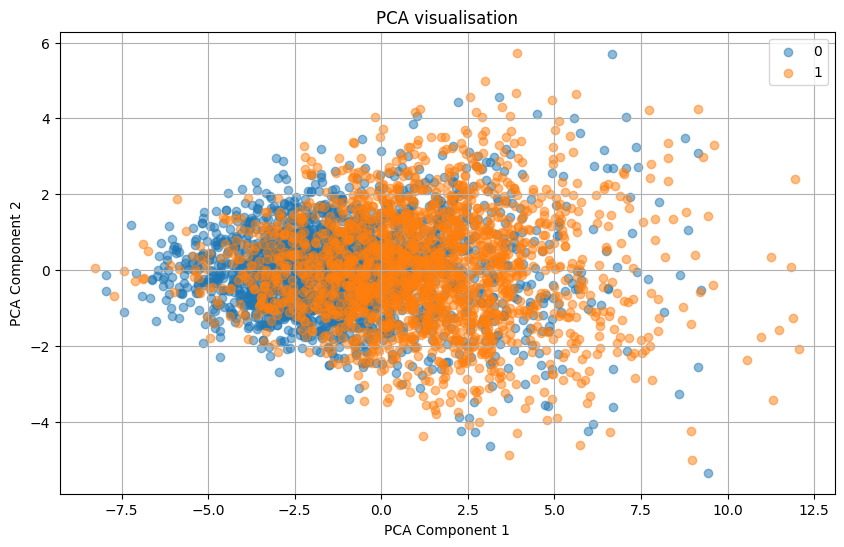

Explained variance ratio: [0.57842027 0.12372302 0.06808332]
PCA components:

Component 1:
Feature 0: 0.3127
Feature 1: 0.3072
Feature 2: 0.3300
Feature 3: 0.3164
Feature 4: 0.3139
Feature 5: 0.2635
Feature 6: 0.2950
Feature 7: 0.3039
Feature 8: 0.2842
Feature 9: 0.2982
Feature 226: -0.0132
Feature 235: -0.0013
Feature 425: 0.2135
Feature 462: 0.1894
Feature 471: 0.0075

Component 2:
Feature 0: 0.1730
Feature 1: -0.0619
Feature 2: 0.0261
Feature 3: -0.1669
Feature 4: 0.2164
Feature 5: 0.2495
Feature 6: -0.1143
Feature 7: 0.3051
Feature 8: -0.3415
Feature 9: -0.2854
Feature 226: 0.0004
Feature 235: -0.0023
Feature 425: -0.4843
Feature 462: 0.5384
Feature 471: 0.0069

Component 3:
Feature 0: 0.0484
Feature 1: 0.1729
Feature 2: -0.0266
Feature 3: -0.0896
Feature 4: 0.0949
Feature 5: -0.2306
Feature 6: -0.1857
Feature 7: -0.0011
Feature 8: -0.0929
Feature 9: 0.0794
Feature 226: 0.5037
Feature 235: 0.6856
Feature 425: 0.1696
Feature 462: 0.1425
Feature 471: 0.2729


In [49]:
selector = SelectKBest(mutual_info_classif, k=15)
x_train_selected = selector.fit_transform(x_train, y_train)
selected_features = selector.get_support(indices=True)

print("Selected features", selected_features)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_selected)

pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_scaled)

plt.figure(figsize=(10,6))
plt.scatter(x_train_pca[y_train==0, 0], x_train_pca[y_train==0, 1], alpha=0.5, label='0')
plt.scatter(x_train_pca[y_train==1, 0], x_train_pca[y_train==1, 1], alpha=0.5, label='1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA visualisation')
plt.legend()
plt.grid(True)
plt.show()

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("PCA components:")
for i, comp in enumerate(pca.components_, 1):
    print(f"\nComponent {i}:")
    for idx, weight in zip(selected_features, comp):
        print(f"Feature {idx}: {weight:.4f}")

We can see that there is a little bit difference in

Centroid as prototype attitude

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

for k in range(1, 11):
    correct_positives_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train), 1):
        x_tr_fold, y_tr_fold = x_train[train_idx], y_train[train_idx]
        x_val_fold, y_val_fold = x_train[val_idx], y_train[val_idx]

        selector = SelectKBest(mutual_info_classif, k=k)
        x_tr_selected = selector.fit_transform(x_tr_fold, y_tr_fold)
        x_val_selected = selector.transform(x_val_fold)

        scaler = StandardScaler()
        x_tr_scaled = scaler.fit_transform(x_tr_selected)
        x_val_scaled = scaler.transform(x_val_selected)

        centroid_1 = x_tr_scaled[y_tr_fold == 1].mean(axis=0)
        dists_val = np.linalg.norm(x_val_scaled - centroid_1, axis=1)
        top_200_val_idx = np.argsort(dists_val)[:200]

        correct_positives = np.sum(y_val_fold[top_200_val_idx] == 1)
        correct_positives_list.append(correct_positives)

        print(f"k={k} | Fold {fold} - Selected 1: {correct_positives} of 200")

    avg_correct = np.mean(correct_positives_list)
    print(f"k={k} | Average: {avg_correct:.2f}")

k=1 | Fold 1 - Selected 1: 144 of 200
k=1 | Fold 2 - Selected 1: 136 of 200
k=1 | Fold 3 - Selected 1: 149 of 200
k=1 | Fold 4 - Selected 1: 140 of 200
k=1 | Fold 5 - Selected 1: 143 of 200
k=1 | Average: 142.40
k=2 | Fold 1 - Selected 1: 143 of 200
k=2 | Fold 2 - Selected 1: 128 of 200
k=2 | Fold 3 - Selected 1: 148 of 200
k=2 | Fold 4 - Selected 1: 137 of 200
k=2 | Fold 5 - Selected 1: 130 of 200
k=2 | Average: 137.20
k=3 | Fold 1 - Selected 1: 133 of 200
k=3 | Fold 2 - Selected 1: 119 of 200
k=3 | Fold 3 - Selected 1: 142 of 200
k=3 | Fold 4 - Selected 1: 133 of 200
k=3 | Fold 5 - Selected 1: 129 of 200
k=3 | Average: 131.20
k=4 | Fold 1 - Selected 1: 127 of 200
k=4 | Fold 2 - Selected 1: 117 of 200
k=4 | Fold 3 - Selected 1: 139 of 200
k=4 | Fold 4 - Selected 1: 126 of 200
k=4 | Fold 5 - Selected 1: 124 of 200
k=4 | Average: 126.60
k=5 | Fold 1 - Selected 1: 129 of 200
k=5 | Fold 2 - Selected 1: 119 of 200
k=5 | Fold 3 - Selected 1: 138 of 200
k=5 | Fold 4 - Selected 1: 119 of 200


We can see that probably this way of calculating centroids is to simple and additional fetures even make situation worse. We can try prototypical networks concepts which learn embeddings to better distuingish between different classes.

In [ ]:
DEVICE = "cpu"
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
x_train_full, x_test, y_train_full, y_test = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

In [ ]:
scaler = StandardScaler()
x_train_full = scaler.fit_transform(x_train_full)
x_test = scaler.transform(x_test)

In [4]:
results = []

for k in range(1, 15):
    print(f"\n Testing with top {k} variables ")

    selector = SelectKBest(mutual_info_classif, k=k)
    x_train_k = selector.fit_transform(x_train, y_train)
    selected_features = selector.get_support(indices=True)

    #Considering different splits in different epochs wasn't improving results
    x_support, x_query, y_support, y_query = train_test_split(
        x_train_k, y_train, test_size=0.3, stratify=y_train
    )

    x_support = torch.tensor(x_support, dtype=torch.float32).to(DEVICE)
    y_support = torch.tensor(y_support, dtype=torch.long).to(DEVICE)
    x_query = torch.tensor(x_query, dtype=torch.float32).to(DEVICE)
    y_query = torch.tensor(y_query, dtype=torch.long).to(DEVICE)
    x_full_train_tensor = torch.tensor(x_train_k, dtype=torch.float32).to(DEVICE)
    y_full_train_tensor = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

    # Maybe it could be optimized, because we have small dimensionlity after feature selection
    class Encoder(nn.Module):
        def __init__(self, input_dim, embedding_dim=4):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 8),
                nn.ReLU(),
                nn.Linear(8, embedding_dim)
            )
        def forward(self, x):
            return self.net(x)

    model = Encoder(input_dim=x_support.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()


    for epoch in range(300):
        model.train()
        optimizer.zero_grad()

        support_embed = model(x_support)
        proto_0 = support_embed[y_support == 0].mean(0)
        proto_1 = support_embed[y_support == 1].mean(0)
        prototypes = torch.stack([proto_0, proto_1])

        query_embed = model(x_query)
        dists = torch.cdist(query_embed, prototypes)
        preds = F.log_softmax(-dists, dim=1)

        loss = loss_fn(preds, y_query)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            y_pred = preds.argmax(1).detach().cpu().numpy()
            y_true = y_query.cpu().numpy()
            prec = precision_score(y_true, y_pred, zero_division=0)
            print(f"Epoch {epoch} - Loss: {loss.item():.4f} - Query Precision: {prec:.4f}")

    # I choose this method of evaluation more as heuristic to
    # compare different number of features rather than proper testing set
    with torch.no_grad():
        embed_full = model(x_full_train_tensor)
        proto_1_final = embed_full[y_full_train_tensor == 1].mean(0, keepdim=True)
        dists_to_proto1 = torch.norm(embed_full - proto_1_final, dim=1)
        topk_indices = torch.topk(-dists_to_proto1, 1000).indices.cpu().numpy()

        correct_positives = y_train[topk_indices].sum()
        reward = int(correct_positives) * 10
        cost = k * 200
        final_score = reward - cost

        results.append((k, int(correct_positives), reward, cost, final_score))
        print(f"Correctly identified: {int(correct_positives)} | Variables: {k} | Score: EUR {final_score}")



=== Testing with top 1 variables (different split each time) ===
Epoch 0 - Loss: 0.6030 - Query Precision: 0.7232
Epoch 10 - Loss: 0.6026 - Query Precision: 0.7233
Epoch 20 - Loss: 0.6004 - Query Precision: 0.7226
Epoch 30 - Loss: 0.5991 - Query Precision: 0.7235
Epoch 40 - Loss: 0.5988 - Query Precision: 0.7250
Epoch 50 - Loss: 0.5984 - Query Precision: 0.7250
Epoch 60 - Loss: 0.5980 - Query Precision: 0.7238
Epoch 70 - Loss: 0.5976 - Query Precision: 0.7235
Epoch 80 - Loss: 0.5973 - Query Precision: 0.7250
Epoch 90 - Loss: 0.5970 - Query Precision: 0.7250
Epoch 100 - Loss: 0.5967 - Query Precision: 0.7271
Epoch 110 - Loss: 0.5966 - Query Precision: 0.7290
Epoch 120 - Loss: 0.5964 - Query Precision: 0.7279
Epoch 130 - Loss: 0.5963 - Query Precision: 0.7283
Epoch 140 - Loss: 0.5962 - Query Precision: 0.7260
Epoch 150 - Loss: 0.5961 - Query Precision: 0.7271
Epoch 160 - Loss: 0.5960 - Query Precision: 0.7271
Epoch 170 - Loss: 0.5959 - Query Precision: 0.7267
Epoch 180 - Loss: 0.5958 - 